# Movie Recommendation Challenge: Team_3_CPT

# Introduction

**Problem** : Predicting how a user will rate a movie they have not yet viewed based on their historical preferences.

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase - generating revenue and platform affinity.

# Imports

In [ ]:
#Importing the required packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import warnings; warnings.simplefilter('ignore')
from collections import defaultdict
from wordcloud import WordCloud

# The Data

In this section we will be diving deep into the data and what it offers.
We will be doing through analysis and grabbing insights.

We will start by:
* Loading the data
* Viewing the data
* Checking for nan values
* Checking the shapes
* Adding visual comparisons

In [ ]:
# Loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
movies = pd.read_csv('movies.csv')
imdb = pd.read_csv('imdb_data.csv')
# Viewing the data
train.head()


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [ ]:
# Checking the shape
train.shape


In [ ]:
# Looking for nan values
train.isna().sum()


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
# Checking the shape
test.shape


(5000019, 2)

In [ ]:
# Looking for nan values
test.isna().sum()


userId     0
movieId    0
dtype: int64

Conclusion: both the train and test datasets contain no null values.

In [ ]:
# Function for changing the labels.
def changingLabels(number):
    return str(number/10**6) + "M"
    

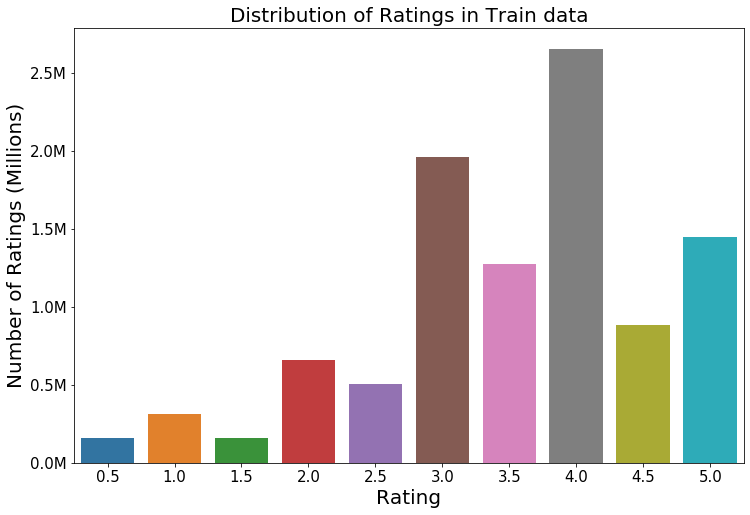

In [ ]:
# Plotting a bar graph to visualise distribution of ratings in the train data
plt.figure(figsize=(12, 8))
ax = sns.countplot(x="rating", data=train)
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize=15)
plt.title("Distribution of Ratings in Train data", fontsize=20)
plt.xlabel("Rating", fontsize=20)
plt.ylabel("Number of Ratings (Millions)", fontsize=20)
plt.show()


We can clearly see that Ratings equal to 4.0 are most common.

We believe that the reasons for this might be because it is likely that people who truely enjoyed a specific movie will never be 100% satisfied with the movie. Giving a 5.0 rating would indicate a truly perfect movie from the watchers perspective, which is very rare. The closest best thing to 5.0 without seeming bias is 4.0, therefore 4.0 ratings are most common.

In [ ]:
no_of_ratings_per_movie = train.groupby(by="movieId")["rating"].count().sort_values(ascending=False)


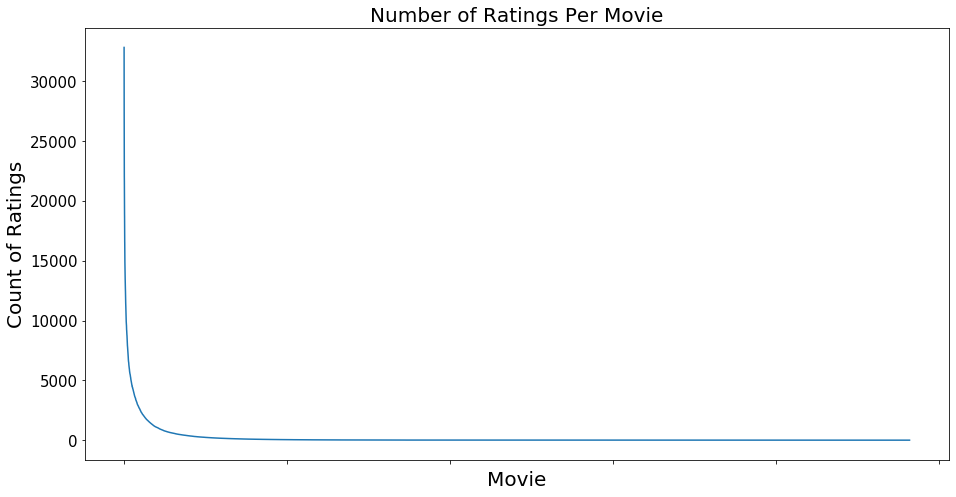

In [ ]:
fig = plt.figure(figsize=(12, 6))
axes = fig.add_axes([0.1, 0.1, 1, 1])
plt.title("Number of Ratings Per Movie", fontsize=20)
plt.xlabel("Movie", fontsize=20)
plt.ylabel("Count of Ratings", fontsize=20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize=5)
axes.set_xticklabels([])
plt.show()


The above line graph shows that there are some movies that receive many ratings and some movies that receive very little votes.

We believe the reason for this can be the fact that some mainstream movies are way more popular and therefore receive a lot of attention compared to the other movies. 

In [ ]:
no_of_rated_movies_per_user = train.groupby(by="userId")["rating"].count().sort_values(ascending=False)
no_of_rated_movies_per_user.head(10)


userId
72315     12952
80974      3680
137293     3588
33844      3208
20055      3050
109731     2671
49403      2670
92046      2579
110971     2288
30879      2284
Name: rating, dtype: int64

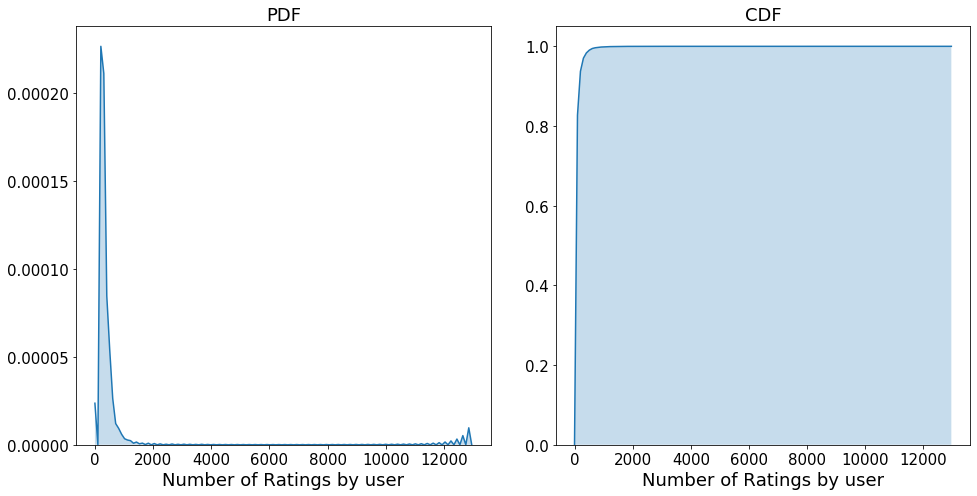

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade=True, ax=axes[0])
axes[0].set_title("PDF", fontsize=18)
axes[0].set_xlabel("Number of Ratings by user", fontsize=18)
axes[0].tick_params(labelsize=15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade=True, cumulative=True, ax=axes[1])
axes[1].set_title("CDF", fontsize=18)
axes[1].set_xlabel("Number of Ratings by user", fontsize=18)
axes[1].tick_params(labelsize=15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()


In [ ]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0, 1.01, 0.01))


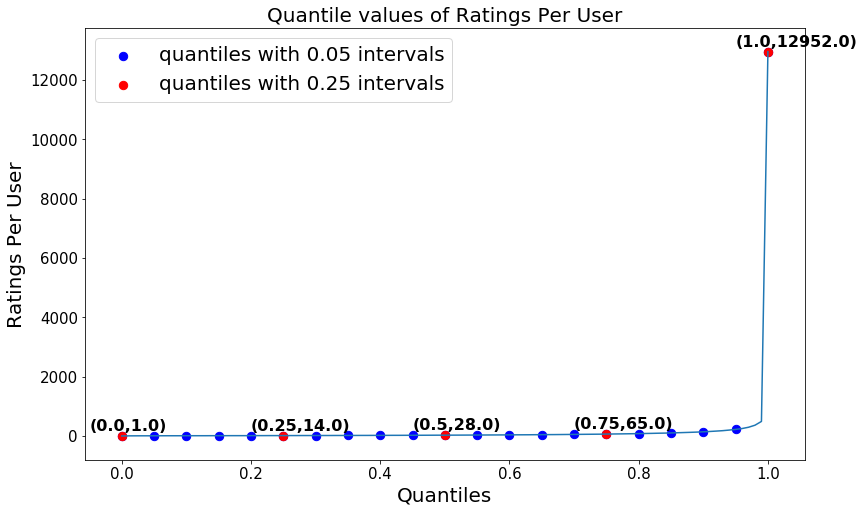

In [ ]:
fig = plt.figure(figsize=(10, 6))

axes = fig.add_axes([0.1, 0.1, 1, 1])
axes.set_title("Quantile values of Ratings Per User", fontsize=20)
axes.set_xlabel("Quantiles", fontsize=20)
axes.set_ylabel("Ratings Per User", fontsize=20)
axes.plot(quantiles)

plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c="blue", s=70, label="quantiles with 0.05 intervals")
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c="red", s=70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize=20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s='({},{})'.format(x, y), xy=(x, y), fontweight='bold', fontsize=16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize=15)


**Finding the most popular genre:**

We began by creating a list of all the genres.

In [ ]:
temp = ""
for i in movies.genres:
    temp = temp+'|'+i

genres_list = list(set(temp.split('|')))
del genres_list[0]  # Data Cleaning
genres_list


['Fantasy',
 'Thriller',
 'War',
 'Romance',
 'Adventure',
 'Film-Noir',
 'Sci-Fi',
 'Mystery',
 'Documentary',
 '(no genres listed)',
 'Western',
 'Animation',
 'Comedy',
 'Action',
 'Horror',
 'IMAX',
 'Children',
 'Drama',
 'Crime',
 'Musical']

Word cloud based on number of movies for each genre.
Here we can see that, adventure, drama, comedy, animation and action are the most popular genres.

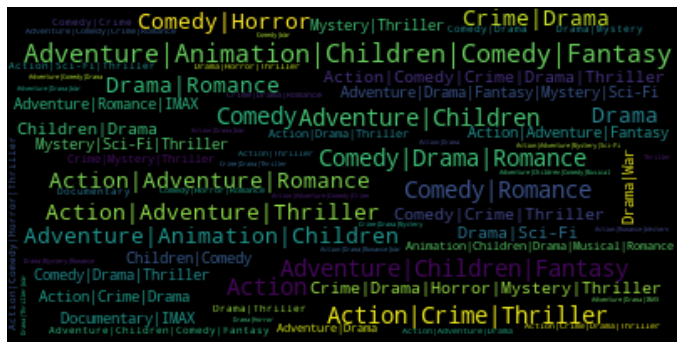

In [ ]:
dict_freq = {}
for i in movies.genres:
    dict_freq[i] = len(genres_list)
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=dict_freq)
plt.figure(figsize=(12, 25))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [ ]:
imd_movies = movies.merge(imdb, on='movieId')
imd_movies.head()


,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Grumpier Old Men (1995),Comedy|Romance,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


The table above is merged data from two different tables and it summarises the data we have on movie titles, it gives insight into movie genres, cast, directors, budgets etc.

# Collaborative Filtering

We will use a technique called collaborative filtering to make recommendations to movie watchers. Collaborative filtering is the most common technique used when it comes to building intelligent recommender systems that can learn to give better recommendations as more information about users is collected.

We will not be implementing collaborative filtering from scratch. Instead, we will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

Most websites like Amazon, YouTube, and Netflix use collaborative filtering as a part of their sophisticated recommendation systems. We can use this technique to build recommenders that give suggestions to a user on the basis of the likes and dislikes of similar users.

In [ ]:
# Run if running from colab
!pip install scikit-surprise

In [ ]:
# Importing the surprise packages we need
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
reader = Reader(rating_scale=(1, 5))

In [ ]:
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)
cross_validate(NormalPredictor(), data, cv=2)


{'test_rmse': array([1.44231188, 1.44291394]),
 'test_mae': array([1.15032336, 1.15069725]),
 'fit_time': (12.198026180267334, 19.09763526916504),
 'test_time': (80.99892377853394, 69.83400535583496)}

# Model Building

We chose to use a **Single Value Decomposition (SVD)** algorithm:

One way to handle the scalability and sparsity issue created by colaborative filtering is to leverage a latent factor model to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). The lower the RMSE, the better the performance.

The latent factor you might be wondering is a broad idea which describes a property or concept that a user or an item has. SVD decreases the dimension of the utility matrix by extracting its latent factors. Essentially, we map each user and each item into a latent space with dimension r. Therefore, it helps us better understand the relationship between users and items as they become directly comparable. 

In [ ]:
kf = KFold(n_splits=3)
algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)


RMSE: 0.8462
RMSE: 0.8448
RMSE: 0.8461


Fitting our algorithm on the whole dataset.

In [ ]:
# n_epochs=10, lr_all=0.005, reg_all=0.4

In [ ]:
algo.fit(data.build_full_trainset())

In [ ]:
# This for loop generates a list containing all our predictions.
ratings = []
for _, row in test.iterrows():
    ratings.append(algo.predict(row.userId, row.movieId).est)

ratings


[3.3706148707804773,
 4.091895812850327,
 3.820082936308193,
 3.9831860466863946,
 2.44968050872426,
 3.8797061813969838,
 3.892173805715824,
 3.5455918378887485,
 3.6382614347199578,
 3.746263642854632,
 3.4136503323728675,
 3.167403477366628,
 3.8572113720042545,
 4.652854335979527,
 3.920466526081389,
 3.99702005718648,
 3.417476794270497,
 3.229972194882529,
 3.914479998682188,
 3.6341083809133403,
 4.070835681085253,
 3.669843563942626,
 3.2449195676233393,
 3.0642037619452673,
 3.3969672867290153,
 3.3850446437634387,
 4.04529893166699,
 3.283878669486287,
 3.2352472552611764,
 3.5359865418873992,
 4.09998947193307,
 3.4311483311876847,
 3.3633402253204436,
 3.2393581388047785,
 3.104130595431437,
 3.0474165872945393,
 3.376267640762961,
 3.5592993183662327,
 5,
 3.4328622599073713,
 4.244436904001442,
 3.3389894424015973,
 4.8000857291108545,
 3.7187960120572,
 4.3834217565107165,
 3.5411800795783517,
 4.007371172888837,
 4.510701378252783,
 3.898029952384657,
 4.340298801093006

In [ ]:
test['rating'] = ratings
test.head()


,userId,movieId,rating
0,1,2011,3.370615
1,1,4144,4.091896
2,1,5767,3.820083
3,1,6711,3.983186
4,1,7318,2.449681


In [ ]:
test['Id'] = test[['userId', 'movieId']].astype(str).agg('_'.join, axis=1)


In [ ]:
# Creating our submission csv file. Score of 0.81885.
test_df = test.copy()
test_df.drop(columns=['movieId', 'userId'], inplace=True)
test_df.to_csv('Submission_5.csv', index=False)
test_df


,rating,Id
0,3.370615,1_2011
1,4.091896,1_4144
2,3.820083,1_5767
3,3.983186,1_6711
4,2.449681,1_7318
...,...,...
5000014,3.839661,162541_4079
5000015,3.781336,162541_4467
5000016,2.716951,162541_4980
5000017,3.058798,162541_5689


In [ ]:
ratings_dict = {'itemId': list(train.movieId),
                'userId': list(train.userId),
                'rating': list(train.rating)}

df = pd.DataFrame(ratings_dict)
df.head()


,itemId,userId,rating
0,57669,5163,4.0
1,5,106343,4.5
2,5459,146790,5.0
3,32296,106362,2.0
4,366,9041,3.0


Let's check how good or bad our predictions are:
The following function will create a pandas data frame which will consist of these columns:

UID: user-id

iid: item id

Rui: the rating given by the user

est: rating estimated by the model

Iu: No of items rated by the user

UI: number of users that have rated this item

err: abs difference between predicted rating and the actual rating.

In [ ]:
def get_Iu(uid):
    """ 
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ 
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

    
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_predictions['Iu'] = df_predictions.uid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.iid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.est - df_predictions.rui)


In [ ]:
df_predictions.head(10)


,uid,iid,rui,est,details,Iu,Ui,err
0,17823,97938,3.0,3.750203,{'was_impossible': False},49,2149,0.750203
1,14842,25,4.0,3.938906,{'was_impossible': False},5,5334,0.061094
2,39268,3415,5.0,4.674705,{'was_impossible': False},56,229,0.325295
3,75508,19,2.0,3.730773,{'was_impossible': False},326,5780,1.730773
4,157578,5377,4.0,3.886248,{'was_impossible': False},204,2888,0.113752
5,6184,81562,5.0,4.898289,{'was_impossible': False},226,1723,0.101711
6,110752,25769,4.5,4.227614,{'was_impossible': False},101,121,0.272386
7,63628,6787,5.0,4.319891,{'was_impossible': False},48,1411,0.680109
8,52311,69644,2.5,3.092715,{'was_impossible': False},155,771,0.592715
9,119425,106100,5.0,4.342044,{'was_impossible': False},8,1874,0.657956


 # Top 10 best and worst predictions by model

In [ ]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]


In [ ]:
best_predictions


,uid,iid,rui,est,details,Iu,Ui,err
2924540,151128,109487,5.0,5.0,{'was_impossible': False},225,5887,0.0
2780003,44670,115678,5.0,5.0,{'was_impossible': False},233,3,0.0
968631,9399,1274,5.0,5.0,{'was_impossible': False},121,2458,0.0
1413095,43769,4040,1.0,1.0,{'was_impossible': False},191,491,0.0
715124,45511,349,5.0,5.0,{'was_impossible': False},165,7357,0.0
187018,40209,296,5.0,5.0,{'was_impossible': False},137,21012,0.0
1413014,72897,1089,5.0,5.0,{'was_impossible': False},30,9304,0.0
1873709,83213,49272,5.0,5.0,{'was_impossible': False},52,5415,0.0
1873661,107372,55765,5.0,5.0,{'was_impossible': False},44,2013,0.0
968856,66661,778,5.0,5.0,{'was_impossible': False},38,7726,0.0


In [ ]:
worst_predictions


,uid,iid,rui,est,details,Iu,Ui,err
2085789,93517,736,0.5,5.0,{'was_impossible': False},82,8237,4.5
172915,24869,55052,0.5,5.0,{'was_impossible': False},1125,946,4.5
1198209,129440,55814,0.5,5.0,{'was_impossible': False},460,554,4.5
1921609,128492,318,0.5,5.0,{'was_impossible': False},18,21866,4.5
1938278,2295,51662,0.5,5.0,{'was_impossible': False},19,4967,4.5
2823674,147572,1136,0.5,5.0,{'was_impossible': False},27,10132,4.5
1443269,49598,318,0.5,5.0,{'was_impossible': False},18,21866,4.5
658268,150470,318,0.5,5.0,{'was_impossible': False},55,21866,4.5
2329268,116498,1721,0.5,5.0,{'was_impossible': False},376,9898,4.5
2786046,11295,2324,0.5,5.0,{'was_impossible': False},137,6478,4.5


The worst predictions look pretty surprising. Let's look in more detail of item "2571", rated 0.5, our SVD algorithm predicts that user would rate 5.0

In [ ]:
df.loc[df['itemId'] == 2571]['rating'].describe()


count    29014.000000
mean         4.154253
std          0.912425
min          0.500000
25%          4.000000
50%          4.500000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

This shows that more than 50% users rated this item 4.5 

In [ ]:
# temp = df.loc[df['itemId'] == 4031]['rating']
# configure_plotly_browser_state()

# # Create trace
# trace = go.Histogram(x = temp.values,
#                      name = 'Ratings',
#                      xbins = dict(start = 0,
#                                   end = 5, size=.3))
#  # Create layout
# layout = go.Layout(title = 'Number of ratings item 4031 has received',
#          xaxis = dict(title = 'Number of Ratings Per Item'),
#          yaxis = dict(title = 'Count'),           
#          bargap = 0.2)

# # Create plot
# fig = go.Figure(data=[trace], layout=layout)
# iplot(fig)
# configure_plotly_browser_state()

# # Create trace
# trace = go.Histogram(x = temp.values,
#                      name = 'Ratings',
#                      xbins = dict(start = 0,
#                                   end = 5, size=.3))
#  # Create layout
# layout = go.Layout((title = 'Number of ratings item 3996 has received'),
#          xaxis = dict(title = 'Number of Ratings Per Item'),
#          yaxis = dict(title = 'Count'),
#          bargap = 0.2)  

# # Create plot
# fig = go.Figure(data=[trace], layout=layout)
# iplot(fig)

In [ ]:
#It turns out, most of the ratings this Item received between "3 and 5",only 1% of the users rated "0.5" and one "2.5"below 3. It seems that for each prediction, the users are some kind of outliers and the item has been rated very few number of times.

# K Recommendations

Recall and precision at K Recall and precision are the classical evaluation metric and are used to evaluate the binary metric and so we have to convert our rating which is scaled from (1-5) into a binary problem relevant and not relevant items.

#Conversion to binary

To do the translation we have to select an arbitrary value on which we can say any rating above that will be considered relevant. There are many methods on selecting that value but for now, we will select 3.5 as the threshold, which means any true rating above 3.5 will be considered relevant and below will be not relevant.

Deciding 'k'

In recommendation systems, we are interested in showing the top N items to users and so the best way is to compute precision and recall on top N values instead of calculating on all the items.

Definition of Relevant and Recommended
Relevant: True Rating > = 3.5

Irrelevant: True Rating < 3.5

Recommended item: Predicted Rating > = 3.5

Not Recommended item: Predicted Rating > = 3.5

Definition of Precision and Recall
Precision: It tries to answer "What proportion of positive identifications was actually correct?" i.e True positive / (True positive+False Positive) in RecSys we can say (number of recommended items at k that are relevant) / (number of recommended items at k)

Recall: It tries to answer "What proportion of actual positives were identified correctly?" i.e True positive / (True Positive+False Negative) in RecSys we can say (# of recommended items @k that are relevant) / (# of relevant items @k)

While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant.

In some circumstances, we might know that we need to maximize either recall or precision at the cost of the other metric. For example, in disease screening of patients, we would probably want a recall near 1.0 i.e. we want to find all patients who have the disease.

However, in cases where we want to obtain an optimal blend of precision and recall, we can use F1 score which is the harmonic mean of precision and recall taking both metrics into account while calculating it.

f1 score = 2 * (precision * recall) / (precision + recall)

The below function computes precision and recall and F1 socre as explained above.

In [ ]:
#Calculate TP,FP,TN,FN at every threshold level (0.0 - 5.0)
final = []

for threshold in np.arange(0, 5.5, 0.5):
    tp=0
    fn=0
    fp=0
    tn=0
    temp = []

    for uid, _, true_r, est, _ in predictions:
        if(true_r>=threshold):
            if(est>=threshold):
                tp = tp+1
            else:
                fn = fn+1
        else:
            if(est>=threshold):
                fp = fp+1
            else:
                tn = tn+1   

        if tp == 0:
            precision = 0
            recall = 0
            f1 = 0
        else:
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * (precision * recall) / (precision + recall)  

    temp = [threshold, tp,fp,tn ,fn, precision, recall, f1]
    final.append(temp)

results = pd.DataFrame(final)
results.rename(columns={0:'threshold', 1:'tp', 2: 'fp', 3: 'tn', 4:'fn', 5: 'Precision', 6:'Recall', 7:'F1'}, inplace=True)
results

,threshold,tp,fp,tn,fn,Precision,Recall,F1
0,0.0,3333346,0,0,0,1.000000,1.000000,1.000000
1,0.5,3333346,0,0,0,1.000000,1.000000,1.000000
2,1.0,3280854,52492,0,0,0.984252,1.000000,0.992064
3,1.5,3169007,139647,16777,7915,0.957793,0.997509,0.977248
4,2.0,3090603,162284,47606,32853,0.950111,0.989482,0.969397
5,2.5,2808146,285975,143310,95915,0.907575,0.966972,0.936332
6,3.0,2428912,267225,330587,306622,0.900886,0.887911,0.894352
7,3.5,1537200,362653,888607,544886,0.809115,0.738298,0.772086
8,4.0,705635,154575,1519693,953443,0.820306,0.425318,0.560186
9,4.5,124685,50120,2508293,650248,0.713281,0.160898,0.262567


As per the results above, the optimal value for threshold is 2.5.

The next step is to find the optimal K value, and to find if we have to first calculate precision and recall for all the K values(2-10) having threshold value 2.5.

Below is the function to calculate precision and recall at K.

In [ ]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    #tp = n_rel_and_rec_k
    #fn =  n_rel - tp
    #fp = n_rec_k - tp
    return precisions, recalls
    

In [ ]:
results=[]
for i in range(2, 11):
    precisions, recalls = precision_recall_at_k(predictions, k=i, threshold=2.5)

    # Precision and recall can then be averaged over all users
    prec = sum(prec for prec in precisions.values()) / len(precisions)
    rec = sum(rec for rec in recalls.values()) / len(recalls)
    results.append({'K': i, 'Precision': prec, 'Recall': rec})
    

results


[{'K': 2, 'Precision': 0.9487495738944498, 'Recall': 0.3141678895394318},
 {'K': 3, 'Precision': 0.9437520014049048, 'Recall': 0.4222395664685952},
 {'K': 4, 'Precision': 0.9392998440195235, 'Recall': 0.5054984949931255},
 {'K': 5, 'Precision': 0.9357125001292971, 'Recall': 0.5697440365400035},
 {'K': 6, 'Precision': 0.9326581755450418, 'Recall': 0.6203275986351345},
 {'K': 7, 'Precision': 0.9300667159548649, 'Recall': 0.6609331323020061},
 {'K': 8, 'Precision': 0.9279087403655971, 'Recall': 0.6942032497178199},
 {'K': 9, 'Precision': 0.9260151100842618, 'Recall': 0.7220378239475064},
 {'K': 10, 'Precision': 0.9242910612032065, 'Recall': 0.745568854604394}]

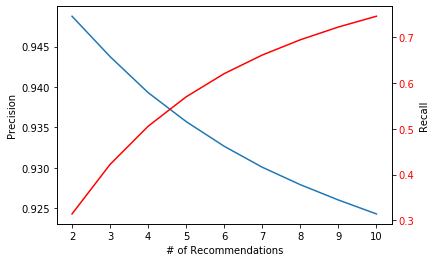

In [ ]:
Rec = []
Precision = []
Recall = []
for i in range(0, 9):
    Rec.append(results[i]['K'])
    Precision.append(results[i]['Precision'])
    Recall.append(results[i]['Recall'])

plt.plot(Rec, Precision)
plt.xlabel('# of Recommendations')
plt.ylabel('Precision')
plt2 = plt.twinx()
plt2.plot(Rec, Recall, 'r')
plt.ylabel('Recall')

for tl in plt2.get_yticklabels():
    tl.set_color('r')


As the graph states, Precision drops significantly when K=4

So we will consider the value of K to be 4.

 #  Testing Model's Recommendation Ability

As we know the optimal number of recommendations to provide, it's time to give recommendations to users. To do so we have to predict ratings for the movies which user have not yet watched.

Here we will be using build_anti_testset() method to get the data for testset as we have to predict ratings for the (user, item) pairs which are not present.

In [ ]:
# trainset = data.build_full_trainset()   #Build on entire data set
# algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)
# algo.fit(trainset)

# # Predict ratings for all pairs (u, i) that are NOT in the training set.
# testset = trainset.build_anti_testset()

# #Predicting the ratings for testset
# predictions = algo.test(testset)

In [ ]:
def get_all_predictions(predictions):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n
    

In [ ]:
all_pred = get_all_predictions(predictions)


As we have all the predicted rating, we'll subset to only top K movies for every user, where K is 4

In [ ]:
#To get top 4 recommendation
n = 4

for uid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[uid] = user_ratings[:n]
    

In [ ]:
tmp2 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in all_pred.items() ]))
tmp2
tmp_transpose = tmp2.transpose()


In [ ]:
tmp_transpose


,0,1,2,3
17823,"(3275, 3.9575287633168164)","(97938, 3.750202876445165)","(99114, 3.7024040635416595)","(1682, 3.6912590036573354)"
14842,"(1, 4.3652069414259)","(82, 4.265690597106493)","(6, 4.255950235977407)","(608, 4.151351352742884)"
39268,"(171011, 4.856004286685006)","(109487, 4.79049399412615)","(6643, 4.73648560409993)","(3415, 4.674704800526225)"
75508,"(4979, 4.825249319048921)","(4848, 4.682161578469242)","(353, 4.578342504331273)","(1732, 4.554811293130001)"
157578,"(1203, 4.578107729820364)","(969, 4.524531765842394)","(1207, 4.515297095431834)","(904, 4.477416242824989)"
...,...,...,...,...
128313,"(58559, 4.28075868114585)",NaN,NaN,NaN
152131,"(356, 3.7473589057080803)",NaN,NaN,NaN
6081,"(2959, 4.277902227640283)",NaN,NaN,NaN
155644,"(2571, 4.320002357875078)",NaN,NaN,NaN


Now we have a dataframe which consits of top 4 movies recommended to every user.
Let's try one example and find recommendations for user 67.

Also in our streamlit app.

In [ ]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results
    

In [ ]:
user_id = 67
results = get_predictions(user_id)
results


0     (2028, 3.736218593802135)
1    (1907, 3.4165874448121807)
2    (1688, 3.3503556090175537)
3    (2353, 3.3053163835887776)
Name: 67, dtype: object

Above matrix is showing top "4" recommendations for user 67. (Movie-id, Predicted-Rating).
But we just need the movies not the ratings, so let's extract the movie id's from the result.

In [ ]:
recommended_movie_ids = []
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids


[2028, 1907, 1688, 2353]

Now as we have the movie-id's to be recommended, Let's find out the movie details of those id's by reading the movie data.

In [ ]:
movies = pd.read_csv('movies.csv')
movies.head()
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
recommended_movies


,movieId,title,genres
1626,1688,Anastasia (1997),Adventure|Animation|Children|Drama|Musical
1818,1907,Mulan (1998),Adventure|Animation|Children|Comedy|Drama|Musi...
1939,2028,Saving Private Ryan (1998),Action|Drama|War
2262,2353,Enemy of the State (1998),Action|Thriller


In [ ]:
ratings_dict = {'itemId': list(train.movieId),
                'userId': list(train.userId),
                'rating': list(train.rating)}

df = pd.DataFrame(ratings_dict)
df.head()


,itemId,userId,rating
0,57669,5163,4.0
1,5,106343,4.5
2,5459,146790,5.0
3,32296,106362,2.0
4,366,9041,3.0


In [ ]:
temp = df[df['userId'] == 67].sort_values("rating", ascending = False)
temp.head()


,itemId,userId,rating
6344287,2571,67,5.0
3004,2193,67,4.0
2455852,891,67,4.0
9523893,2089,67,4.0
8360207,1752,67,4.0


In [ ]:
temp.shape


(49, 3)

We can see that user 67 have rated 49 movies

In [ ]:
history_movie_ids = temp['itemId']
user_history = movies[movies['movieId'].isin(history_movie_ids)]


In [ ]:
user_history[:n]


,movieId,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
18,19,Ace Ventura: When Nature Calls (1995),Comedy
43,44,Mortal Kombat (1995),Action|Adventure|Fantasy
108,110,Braveheart (1995),Action|Drama|War


Now we can compare the results with the user history and see how relevant the recommendations are.


Above is the user history and below the recommended movies

In [ ]:
recommended_movies


,movieId,title,genres
1626,1688,Anastasia (1997),Adventure|Animation|Children|Drama|Musical
1818,1907,Mulan (1998),Adventure|Animation|Children|Comedy|Drama|Musi...
1939,2028,Saving Private Ryan (1998),Action|Drama|War
2262,2353,Enemy of the State (1998),Action|Thriller


The history of the user tells that they enjoy movies in the Adventure, Children,Animation, Drama, Comedy, Action and War genres. Our model recommends movies in the same genres, this gives us a good indication that our model has very good predictive/recommendation ability.

# Appendix A

This section contains things that might have not worked, our previous models and some testing we did. Feel free to have a look at everything we attempted. 


In [ ]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [5, 10],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


In [ ]:
from surprise.model_selection import train_test_split

# Setting the data variable and using the Reader() object.
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader=reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8883


0.8882637494815175

In [ ]:
# Using algorithm with best 'rmse'
algo = gs.best_estimator['rmse']

# Fitting it to our full trainset
algo.fit(data.build_full_trainset())

In [ ]:
ratings = []
for _, row in test.iterrows():
    ratings.append(algo.predict(row.userId, row.movieId).est)

ratings

In [ ]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.993054,0.993151,0.990496,0.992234,0.001229,7,0.775013,0.775300,0.773370,0.774561,0.000850,7,5.519943,0.772439,1.587330,0.276665,"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.4}",5,0.002,0.4
1,0.995758,0.996060,0.992963,0.994927,0.001394,8,0.779811,0.779895,0.778041,0.779249,0.000855,8,4.853417,0.034325,1.528982,0.219936,"{'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.6}",5,0.002,0.6
2,0.970135,0.970149,0.966875,0.969053,0.001540,3,0.755282,0.755261,0.753010,0.754518,0.001066,3,4.886498,0.020880,1.583549,0.268445,"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.4}",5,0.005,0.4
3,0.973999,0.974010,0.970796,0.972935,0.001513,4,0.761239,0.761263,0.759049,0.760517,0.001038,5,5.043566,0.164280,1.418149,0.258031,"{'n_epochs': 5, 'lr_all': 0.005, 'reg_all': 0.6}",5,0.005,0.6
4,0.975586,0.975769,0.972843,0.974733,0.001338,5,0.760280,0.760187,0.758710,0.759725,0.000719,4,9.342871,0.108045,1.581257,0.229873,"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.4}",10,0.002,0.4
5,0.979268,0.979243,0.976694,0.978402,0.001207,6,0.765987,0.766041,0.764387,0.765471,0.000767,6,9.292656,0.044363,1.555506,0.247967,"{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.6}",10,0.002,0.6
6,0.953947,0.954159,0.950827,0.952978,0.001523,1,0.741951,0.742139,0.739845,0.741312,0.001040,1,9.280040,0.068097,1.560780,0.242003,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4
7,0.958886,0.959029,0.956025,0.957980,0.001384,2,0.748771,0.748727,0.746814,0.748104,0.000912,2,9.150445,0.028648,1.502130,0.220085,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}",10,0.005,0.6


Looking at the other data:

In [ ]:
movies = pd.read_csv('movies.csv')
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')
sample = pd.read_csv('sample_submission.csv')


# Conclusion

In our experiemnt we have made use of the Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.


The performance of the model was rated based on the RMSE and the lower the RMSE, the better. We have managed to successfully optain an RMSE lower than 0.85.

As we assessed the overall performance of the model based on other non-statistical aspects we can conclude that the model has a high predictive ability as it recommends movies of similar genres to users.

This has an immense economic potential for the service providers and provides a pleasant experience to the consumers of the content.